In [1]:
from calibrate import Calibrate

import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
import os
%matplotlib inline



In [2]:
# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')
output_images = "output_images/"
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

calibrate = Calibrate(images, nx, ny)
print("Calibration Complete")

Calibration Complete


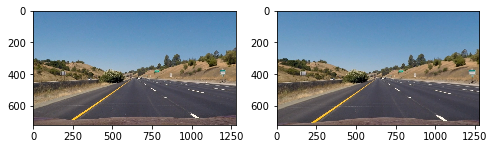

In [3]:
images = glob.glob('./test_images/*.jpg')
undistorted_images = "undistorted_images"
if not os.path.exists(output_images+undistorted_images):
    os.makedirs(output_images+undistorted_images)
undistorted_images += "/"

rows = len(images)

fig = plt.figure(figsize=(8, 25))
for i in range(1):
    img = mpimage.imread(images[i])
    undistorted_img = calibrate.undistort(img)
    output_fname = output_images+undistorted_images+images[i].split("\\")[-1]
    cv2.imwrite(output_fname, cv2.cvtColor(undistorted_img, cv2.COLOR_RGB2BGR))
    fig.add_subplot(rows, 2, i*2+1)
    plt.imshow(img)
    fig.add_subplot(rows, 2, i*2+2)
    plt.imshow(undistorted_img)
plt.show()

In [4]:
import thresholdutil as tu
def threshold_pipeline(img):
    mag_binary = tu.mag_thresh(img, mag_thresh=(70, 255))
    dir_binary = tu.dir_threshold(img, sobel_kernel=5, thresh=(0.7, 1.3))
    sx_binary = tu.abs_sobel_thresh(img, sobel_kernel=15, thresh=(70, 255))
    
    hls_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hls_binary = tu.binary_threshold(hls_img[:,:,2], thresh=(200,255))
    
    res_bin = np.zeros_like(dir_binary)
    res_bin[(dir_binary==1) & (mag_binary==1)] = 1
    res_bin[(hls_binary==1) | (sx_binary==1)] = 1
    
    return res_bin

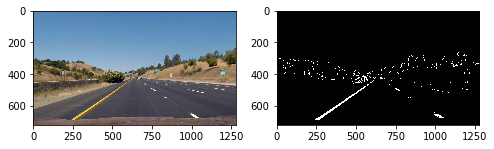

In [5]:

images = glob.glob('./test_images/*.jpg')
thresholded_images = "thresholded_images"
if not os.path.exists(output_images+thresholded_images):
    os.makedirs(output_images+thresholded_images)
thresholded_images += "/"

rows = len(images)

fig = plt.figure(figsize=(8, 25))
for i in range(1):
    img = mpimage.imread(images[i])
    output_fname = output_images+thresholded_images+images[i].split("\\")[-1]
    
    res_bin = threshold_pipeline(img)
    output_img = np.dstack((res_bin, res_bin, res_bin))*255
    
    cv2.imwrite(output_fname, output_img)
    fig.add_subplot(rows, 2, i*2+1)
    plt.imshow(img)
    fig.add_subplot(rows, 2, i*2+2)
    plt.imshow(output_img)
plt.show()

In [6]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


In [7]:
from perspectivetransform import PerspectiveTransform
xy_bl = (230, 693)
xy_tl = (591, 450)
xy_tr = (689, 450)
xy_br = (1076, 693)
src_pts = [xy_bl, xy_tl, xy_tr, xy_br]

xy_bl = (300, 719)
xy_tl = (300, 0)
xy_tr = (980, 0)
xy_br = (980, 719)
dst_pts = [xy_bl, xy_tl, xy_tr, xy_br]
pt = PerspectiveTransform(src_pts, dst_pts)

xy_bl = (150, 720)
xy_tl = (451, 450)
xy_tr = (839, 450)
xy_br = (1130, 720)
roi_pts = np.array([[xy_bl, xy_tl, xy_tr, xy_br]])


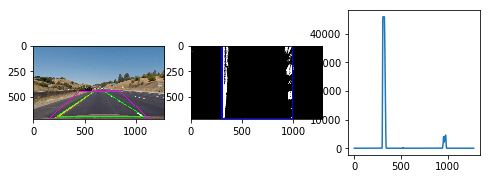

In [8]:

#images = ['./test_images/straight_lines1.jpg']
images = glob.glob('./test_images/*.jpg')
perspective_images = "perspective_images"
if not os.path.exists(output_images+perspective_images):
    os.makedirs(output_images+perspective_images)
perspective_images += "/"

rows = len(images)

fig = plt.figure(figsize=(8, 25))
for i in range(1):
    img = mpimage.imread(images[i])
    output_fname = output_images+perspective_images+images[i].split("\\")[-1]
    output_undist_fname = output_images+perspective_images+"undist_"+images[i].split("\\")[-1]
    
    undistorted_img = calibrate.undistort(img)
    thresh_img = threshold_pipeline(undistorted_img)
    thresh_img = np.dstack((thresh_img, thresh_img, thresh_img))*255
    roi_img = region_of_interest(thresh_img,roi_pts) 
    output_undistorted_img = pt.transform(undistorted_img)
    
    output_img = pt.transform(roi_img)
    
    output_img_gray = output_img[:, :, 0]
    histogram = np.sum(output_img_gray[3*output_img_gray.shape[0]//4:,:],axis=0)
    
    cv2.imwrite(output_undist_fname, cv2.cvtColor(output_undistorted_img, cv2.COLOR_RGB2BGR))
    cv2.imwrite(output_fname, cv2.cvtColor(output_img, cv2.COLOR_RGB2BGR))
    
    cv2.polylines(undistorted_img,np.array([src_pts]),True,(0,255,0),thickness=5)
    cv2.polylines(output_img,np.array([dst_pts]),True,(0,0,255),thickness=10)
    cv2.polylines(undistorted_img,roi_pts,True,(255,0,255),thickness=5)
    
    fig.add_subplot(rows, 3, i*3+1)
    plt.imshow(undistorted_img)
    fig.add_subplot(rows, 3, i*3+2)
    plt.imshow(output_img) 
    fig.add_subplot(rows, 3, i*3+3)
    plt.plot(histogram)
    
    

plt.show()

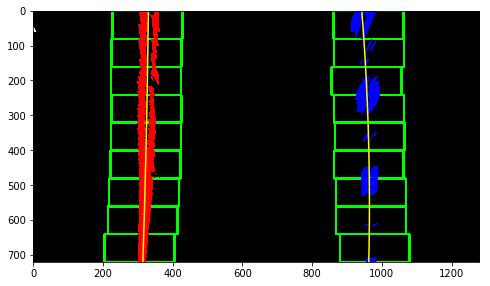

In [9]:
from curveutil import find_base_curve
from curve import Curve

#images = ['./test_images/straight_lines1.jpg']
images = glob.glob('./test_images/*.jpg')
line_images = "line_images"
if not os.path.exists(output_images+line_images):
    os.makedirs(output_images+line_images)
line_images += "/"

rows = len(images)

fig = plt.figure(figsize=(8, 25))

left_curve = Curve()
right_curve = Curve()
for i in range(1):
    img = mpimage.imread(images[i])
    output_fname = output_images+line_images+images[i].split("\\")[-1]
    
    undistorted_img = calibrate.undistort(img)
    thresh_img = threshold_pipeline(undistorted_img)
    #thresh_img = np.dstack((thresh_img, thresh_img, thresh_img))*255
    roi_img = region_of_interest(thresh_img,roi_pts) 
    output_undistorted_img = pt.transform(undistorted_img)
    
    perspective_img = pt.transform(roi_img)
    
    output_img = find_base_curve(perspective_img, left_curve, right_curve)
    
    
    # cv2.imwrite(output_undist_fname, cv2.cvtColor(output_undistorted_img, cv2.COLOR_RGB2BGR))
    # cv2.imwrite(output_fname, cv2.cvtColor(output_img, cv2.COLOR_RGB2BGR))
    # 
    # cv2.polylines(undistorted_img,np.array([src_pts]),True,(0,255,0),thickness=5)
    # cv2.polylines(output_img,np.array([dst_pts]),True,(0,0,255),thickness=10)
    # cv2.polylines(undistorted_img,roi_pts,True,(255,0,255),thickness=5)
    
    # fig.add_subplot(rows, 3, i*3+1)
    # plt.imshow(undistorted_img)
    # fig.add_subplot(rows, 3, i*3+2)
    # plt.imshow(output_img) 
    # fig.add_subplot(rows, 3, i*3+3)
    # plt.plot(histogram)
    ploty = np.linspace(0, output_img.shape[0]-1, output_img.shape[0] )
    left_fitx = left_curve.current_fit[0]*ploty**2 + left_curve.current_fit[1]*ploty + left_curve.current_fit[2]
    right_fitx = right_curve.current_fit[0]*ploty**2 + right_curve.current_fit[1]*ploty + right_curve.current_fit[2]

    plt.imshow(output_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    

    plt.show()

10687.213597304322 2320.0266144850593


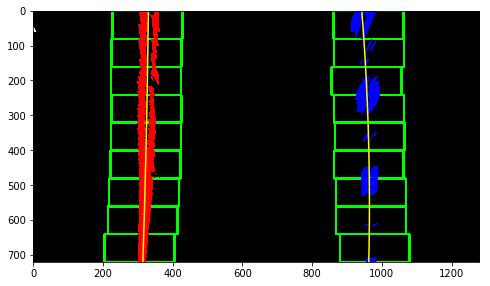

8928.566078776359 2840.9118865911682


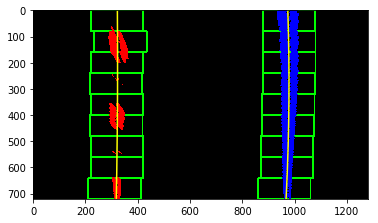

260.86119581259646 485.97550474641724


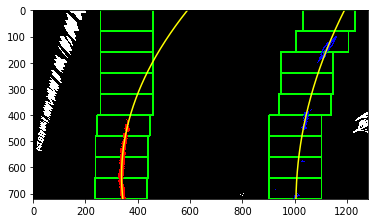

407.05371788556863 373.6621941212401


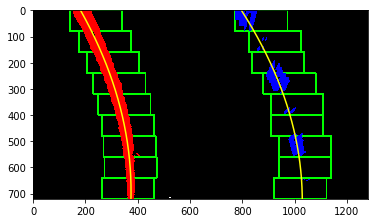

537.2380473246369 548.1652057896324


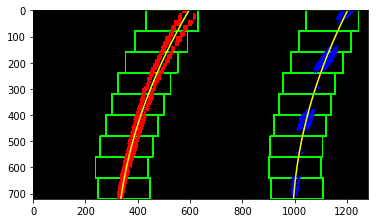

826.2577727026554 437.1555737883335


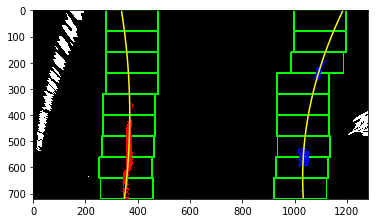

423.79794687832367 335.71593196564396


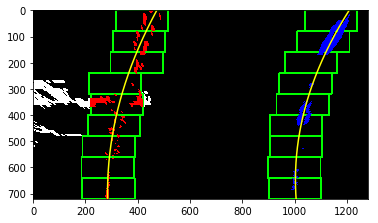

633.5067063103947 976.8027154681498


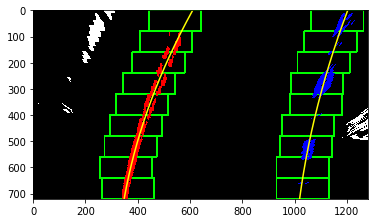

In [11]:
from curveutil import find_base_curve
from curve import Curve

#images = ['./test_images/straight_lines1.jpg']
images = glob.glob('./test_images/*.jpg')
curve_images = "curve_images"
if not os.path.exists(output_images+curve_images):
    os.makedirs(output_images+curve_images)
line_images += "/"

rows = len(images)

fig = plt.figure(figsize=(8, 25))

left_curve = Curve()
right_curve = Curve()
for i in range(rows):
    img = mpimage.imread(images[i])
    output_fname = output_images+curve_images+images[i].split("\\")[-1]
    
    undistorted_img = calibrate.undistort(img)
    thresh_img = threshold_pipeline(undistorted_img)
    #thresh_img = np.dstack((thresh_img, thresh_img, thresh_img))*255
    roi_img = region_of_interest(thresh_img,roi_pts) 
    output_undistorted_img = pt.transform(undistorted_img)
    
    perspective_img = pt.transform(roi_img)
    
    output_img = find_base_curve(perspective_img, left_curve, right_curve)
    
    print(left_curve.radius_of_curvature, right_curve.radius_of_curvature)
    # cv2.imwrite(output_undist_fname, cv2.cvtColor(output_undistorted_img, cv2.COLOR_RGB2BGR))
    # cv2.imwrite(output_fname, cv2.cvtColor(output_img, cv2.COLOR_RGB2BGR))
    # 
    # cv2.polylines(undistorted_img,np.array([src_pts]),True,(0,255,0),thickness=5)
    # cv2.polylines(output_img,np.array([dst_pts]),True,(0,0,255),thickness=10)
    # cv2.polylines(undistorted_img,roi_pts,True,(255,0,255),thickness=5)
    
    # fig.add_subplot(rows, 3, i*3+1)
    # plt.imshow(undistorted_img)
    # fig.add_subplot(rows, 3, i*3+2)
    # plt.imshow(output_img) 
    # fig.add_subplot(rows, 3, i*3+3)
    # plt.plot(histogram)
    ploty = np.linspace(0, output_img.shape[0]-1, output_img.shape[0] )
    left_fitx = left_curve.current_fit[0]*ploty**2 + left_curve.current_fit[1]*ploty + left_curve.current_fit[2]
    right_fitx = right_curve.current_fit[0]*ploty**2 + right_curve.current_fit[1]*ploty + right_curve.current_fit[2]

    plt.imshow(output_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    

    plt.show()